# LLM Sentiment Analysis

Project by Abhi Vellore

Imports

In [1]:
from pre_process import AmazonDatasetPreprocessor, KaggleDatasetPreprocessor, SentenceDatasetPreprocessor
from config import PROCESSED_DATA_PATH
import os
import pandas as pd
from gpt import ChatGPTSession
import glob
from llama import LLaMaSession

import sys
sys.path.insert(0, '..')

from credentials import openai_api_key, llama_api_key

# Preprocess Data

In [ ]:
amazon_processor = AmazonDatasetPreprocessor('Amazon_Fashion_Review_Data.json')
amazon_processor.preprocess()
amazon_processor.to_csv('processed_amazon_data.csv')

# Initialize and process the Sentence data
sentence_processor = SentenceDatasetPreprocessor('Sentences_75Agree.txt')
sentence_processor.preprocess()
sentence_processor.to_csv('processed_sentence_data.csv')

# Initialize and process the first Kaggle dataset
kaggle1_processor = KaggleDatasetPreprocessor('kaggle_train.csv')
kaggle1_processor.preprocess()

# Initialize and process the second Kaggle dataset
kaggle2_processor = KaggleDatasetPreprocessor('kaggle_test.csv')
kaggle2_processor.preprocess()

# Concatenate the preprocessed DataFrames
processed_kaggle1_df = kaggle1_processor.df
processed_kaggle2_df = kaggle2_processor.df
combined_df = pd.concat([processed_kaggle1_df, processed_kaggle2_df], ignore_index=True)

# Sample approximately 3000 rows from the combined DataFrame
sampled_df = combined_df.sample(n=3000, random_state=42)  # random_state for reproducibility

# Save the combined DataFrame to a new CSV file in the processed directory
combined_csv_path = os.path.join(PROCESSED_DATA_PATH, 'processed_kaggle_combined_data.csv')
sampled_df.to_csv(combined_csv_path, index=False)
print(f"Processed combined Kaggle data saved to {combined_csv_path}")

# Models and Experiments

### Set up and Save Functions

Create a series of functions with checks to prevent hitting OpenAI rate limit safeguards and track expenses of running the datasets.


In [32]:
import time

# Define state-saving functions
def save_state(state_file, last_processed_index):
    with open(state_file, 'w') as file:
        file.write(str(last_processed_index))

def load_state(state_file):
    try:
        with open(state_file, 'r') as file:
            return int(file.read().strip())
    except FileNotFoundError:
        return 0


In [33]:
daily_limit = 10000
rate_limit_per_minute = 500
state_file_path = 'last_processed_line.txt'


### GPT Model

Create GPT models and use them to perform sentiment analysis

#### Helper Function to process a dataset with GPT - saves into new dataset

In [34]:
def process_dataset_with_GPTModel(input_csv_path, output_csv_path, chat_session, column_name, state_file):
    df = pd.read_csv(input_csv_path)
    start_index = load_state(state_file)  # Load the last processed index
    processed_count = 0

    for index, row in df.iterrows():
        if index < start_index:
            continue  # Skip already processed rows

        # Check if we've reached the daily limit before processing the next row
        if processed_count >= daily_limit:
            print("Reached the daily limit, stopping...")
            break

        # Insert your API call here and store the response
        response = chat_session.send_prompt(row['Text'])
        df.at[index, column_name] = response

        # Save the state after each line is processed
        save_state(state_file, index)
        processed_count += 1

        # Handle rate limiting
        if processed_count % rate_limit_per_minute == 0 and processed_count != 0:
            print("Rate limit reached, sleeping for 60 seconds...")
            time.sleep(60)

    # Save the modified DataFrame
    df.to_csv(output_csv_path, index=False)
    print(f"Processing completed. Data saved to {output_csv_path}")

#### Initialize GPT Models

Sets context to minimize tokens being used.

In [35]:
sentiment_context = "As a sentiment analysis model, rate the sentiment of the following text from 1 to 5, where 1 is very negative and 5 is very positive. Provide only the number as a response."

# Initialize sessions for GPT-3.5-Turbo and GPT-4.0
session_gpt_3_5 = ChatGPTSession(api_key=openai_api_key, model='gpt-3.5-turbo', rate_limit_per_minute=1000)
session_gpt_4 = ChatGPTSession(api_key=openai_api_key, model='gpt-4', rate_limit_per_minute=300)

session_gpt_3_5.set_context(sentiment_context)
session_gpt_4.set_context(sentiment_context)

#### Processing Financial Data

Split into two separate commands to ensure accuracy. Will use a for loop in the future.

In [ ]:
# Process 'processed_sentence_data_.csv' with GPT-3.5
sentence_data_filename = '../data/processed/processed_sentence_data.csv'
output_sentence_path_3_5 = sentence_data_filename.replace('.csv', '_with_gpt_3.5.csv')
df_sentence = process_dataset_with_GPTModel(sentence_data_filename, output_sentence_path_3_5, session_gpt_4, "GPT 4.0 Score", state_file_path)
print(f"Processed {sentence_data_filename} with GPT-4.0 and saved to {output_sentence_path_3_5}")


In [ ]:
# Process 'sentence_data_with_gpt_3_5.csv' with GPT-4.0
sentence_data_filename = '../data/processed/processed_sentence_data_with_gpt_3_5.csv'
output_sentence_path_4 = sentence_data_filename.replace('_with_gpt_3_5.csv', '_with_gpt_scores.csv')
df_sentence = process_dataset_with_GPTModel(sentence_data_filename, output_sentence_path_4, session_gpt_4, "GPT 4.0 Score", state_file_path)
print(f"Processed {sentence_data_filename} with GPT-4.0 and saved to {output_sentence_path_4}")


#### Processing other datasets

After confirming setup works for the financial dataset, process the other dataset

In [ ]:
# Process other datasets with GPT-3.5 and GPT-4.0
other_datasets = ['../data/processed/processed_amazon_data.csv', 
                  '../data/processed/processed_kaggle_combined_data.csv']

for dataset in other_datasets:
    # Process with GPT-3.5
    output_path_3_5 = dataset.replace('.csv', '_with_gpt_3_5.csv')
    df = process_dataset_with_GPTModel(dataset, output_path_3_5, session_gpt_3_5, "GPT 3.5 Score", state_file_path)
    print(f"Dataset processed with GPT-3.5 and saved to {output_path_3_5}")
    
    # Check if daily limit reached after GPT-3.5 processing
    current_index = load_state(state_file_path)
    if current_index + 1 >= daily_limit:
        print("Daily limit reached, please run GPT-4.0 processing tomorrow.")
        continue  # Continue to the next dataset

In [ ]:
for dataset in other_datasets:
    # Process with GPT-4.0
    output_path_4 = dataset.replace('.csv', '_with_gpt_scores.csv')
    df = process_dataset_with_GPTModel(dataset, output_path_4, session_gpt_4, "GPT 4.0 Score", state_file_path)
    print(f"Dataset processed with GPT-4.0 and saved to {output_path_4}")
    
    # Check if daily limit reached after GPT-4.0 processing
    current_index = load_state(state_file_path)
    if current_index + 1 >= daily_limit:
        print("Daily limit reached, please run again tomorrow.")
        continue  # Continue to the next dataset

### LLama Models
Create Llama models and use them to perform sentiment analysis

#### Helper Function to process a dataset with Llama-7b

In [36]:
def process_dataset_with_llama_model(input_csv_path, output_csv_path, llama_session, column_name, state_file):
    df = pd.read_csv(input_csv_path)
    start_index = load_state(state_file)  # Load the last processed index
    processed_count = 0


    for index, row in df.iterrows():
        if index < start_index:
            continue  # Skip already processed rows

        # Check if we've reached the daily limit before processing the next row
        if processed_count >= daily_limit:
            print("Reached the daily limit, stopping...")
            break

        # Insert your API call here and store the response
        response = llama_session.send_prompt(row['text'])
        df.at[index, column_name] = response

        # Save the state after each line is processed
        save_state(state_file, index)
        processed_count += 1

        # Handle rate limiting
        if processed_count % rate_limit_per_minute == 0 and processed_count != 0:
            print("Rate limit reached, sleeping for 60 seconds...")
            time.sleep(60)

    # Save the modified DataFrame
    df.to_csv(output_csv_path, index=False)
    print(f"Processing completed. Data saved to {output_csv_path}")


In [ ]:
# Initialize sessions for Llama-7b
session_llama_7b = LLaMaSession(api_key=llama_api_key, model='llama-7b-chat', rate_limit_per_minute=1000)


#### Processing Financial Data

Split into two separate commands to ensure accuracy.

In [ ]:
# Process 'processed_sentence_data__with_gpt_scores.csv' with GPT-
sentence_data_filename = '../data/processed/processed_sentence_data_with_gpt_scores.csv'
output_sentence_path_7b = sentence_data_filename.replace('_with_gpt_scores.csv', '_all_scores.csv')
process_dataset_with_llama_model(dataset, output_sentence_path_7b, session_llama_7b, "Llama 7B Score", state_file=state_file_path)
print(f"Processed {sentence_data_filename} with llama and saved to {output_sentence_path_7b}")


#### Processing other datasets

After confirming setup works for the financial dataset, process the other dataset

In [ ]:
other_datasets = ['../data/processed/processed_amazon_data_with_gpt_scores.csv', 
                  '../data/processed/processed_kaggle_combined_data_with_gpt_scores.csv']

# Process each dataset with both models
for dataset in other_datasets:
    output_path_7b = dataset.replace('.csv', '_all_scores.csv')
    process_dataset_with_llama_model(dataset, output_path_7b, session_llama_7b, "Llama 7B Score", state_file=state_file_path)
    print(f"Dataset processed with Llama-7B and saved to {output_path_7b}")


    current_index = load_state(state_file_path)
    if current_index + 1 >= daily_limit:
        print("Daily limit reached, please run again tomorrow.")
        break


# Evaluation Metrics

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


## Functions to evaluate performance

In [3]:
def evaluate_model(predictions, actuals, model_name, dataset_name):
    # Numeric evaluation
    accuracy_numeric = accuracy_score(actuals, predictions)
    f1score_numeric = f1_score(actuals, predictions, average='weighted')
    report_numeric = classification_report(actuals, predictions)
    
    # Categorical mapping and evaluation
    label_mapping = {1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'}
    categorical_actuals = actuals.map(label_mapping)
    categorical_predictions = predictions.map(label_mapping)
    accuracy_categorical = accuracy_score(categorical_actuals, categorical_predictions)
    f1score_categorical = f1_score(categorical_actuals, categorical_predictions, average='weighted', labels=['negative', 'neutral', 'positive'])
    report_categorical = classification_report(categorical_actuals, categorical_predictions, labels=['negative', 'neutral', 'positive'])
    
    # Store results in dictionaries
    numeric_results = {
        'Accuracy (Numeric)': accuracy_numeric,
        'F1 Score (Numeric)': f1score_numeric,
        'Classification Report (Numeric)': report_numeric
    }
    
    categorical_results = {
        'Accuracy (Categorical)': accuracy_categorical,
        'F1 Score (Categorical)': f1score_categorical,
        'Classification Report (Categorical)': report_categorical
    }
    
    # Optionally, print the results
    print(f"--- Numeric Evaluation for {model_name} on {dataset_name} ---")
    print(f"Accuracy: {accuracy_numeric:.2f}")
    print(f"F1 Score: {f1score_numeric:.2f}")
    print(report_numeric)
    
    print(f"--- Categorical Evaluation for {model_name} on {dataset_name} ---")
    print(f"Accuracy: {accuracy_categorical:.2f}")
    print(f"F1 Score: {f1score_categorical:.2f}")
    print(report_categorical)
    
    return numeric_results, categorical_results

def plot_confusion_matrix(predictions, actuals, model_name, dataset_name):
    conf_matrix = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 8))
    # Define the labels for your classes
    labels = [1, 2, 3, 4, 5]
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name} - {dataset_name}')
    plt.show()


## Performance

#### Metrics per Model per Dataset

In [ ]:
datasets = ['processed_sentence_data_all_scores.csv', 'processed_kaggle_combined_all_scores.csv', 'processed_amazon_data_all_scores.csv'] 
models = ['GPT_3_5', 'GPT_4', 'LLaMA_7B']  # Replace with your actual model names
metrics_df = pd.DataFrame()
all_scores_df = pd.DataFrame()


for dataset_file in datasets:
    df = pd.read_csv(dataset_file)
    actuals = df['Actual_Score']
    for model in models:
        predictions = df[model]
        numeric_results, categorical_results = evaluate_model(predictions, actuals, model, dataset_file)
        plot_confusion_matrix(predictions, actuals, model, dataset_file)

        # Flatten the results into a single dictionary for the DataFrame
        results_to_store = {
            'Dataset': dataset_file,
            'Model': model,
            'Accuracy (Numeric)': numeric_results['Accuracy (Numeric)'],
            'F1 Score (Numeric)': numeric_results['F1 Score (Numeric)'],
            'Accuracy (Categorical)': categorical_results['Accuracy (Categorical)'],
            'F1 Score (Categorical)': categorical_results['F1 Score (Categorical)']
        }
        metrics_df = pd.concat([metrics_df, pd.DataFrame([results_to_store])], ignore_index=True)

        if all_scores_df.empty:
            # If all_scores_df is empty, initialize it with the score columns
            all_scores_df = df[models].copy()
        else:
            # If all_scores_df already contains data, concatenate along the columns (axis=1)
            all_scores_df = pd.concat([all_scores_df, df[models]], axis=0, ignore_index=True)



#### Aggregated Metrics Across all Datasets Per Model

In [6]:
# Aggregate the results by taking the mean of each metric per model
aggregated_metrics = metrics_df.groupby('Model').agg({
    'Accuracy (Numeric)': 'mean',
    'F1 Score (Numeric)': 'mean',
    'Accuracy (Categorical)': 'mean',
    'F1 Score (Categorical)': 'mean'
}).reset_index()


##### Accuracy and F1

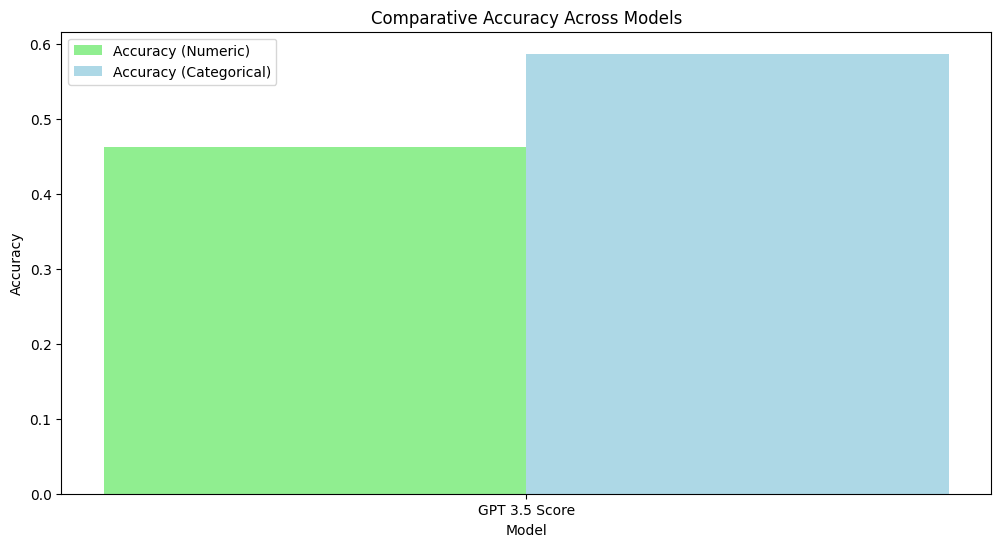

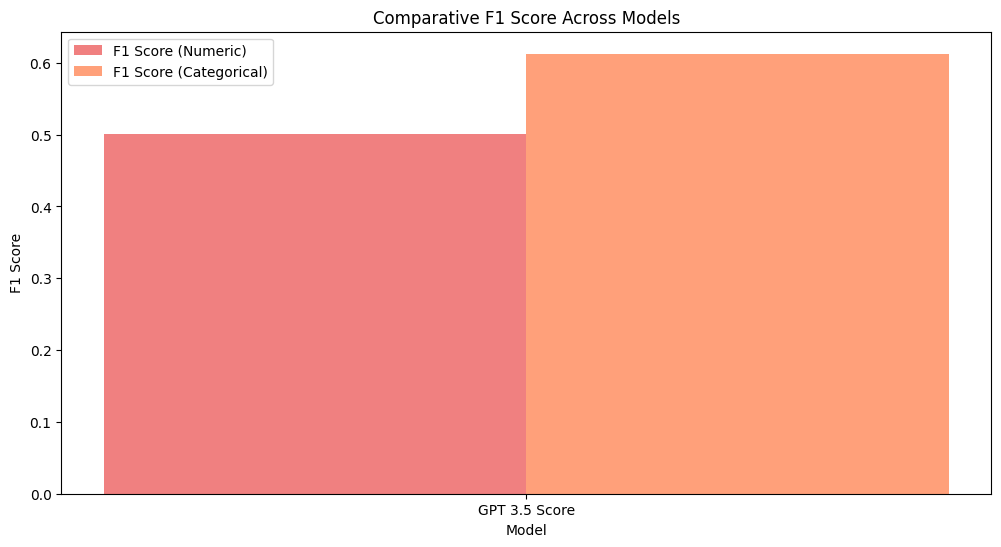

In [7]:
bar_width = 0.35
index = pd.Index(range(len(aggregated_metrics)))

# Create combined plots for accuracy
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, aggregated_metrics['Accuracy (Numeric)'], bar_width, label='Accuracy (Numeric)', color='lightgreen')
plt.bar(index + bar_width/2, aggregated_metrics['Accuracy (Categorical)'], bar_width, label='Accuracy (Categorical)', color='lightblue')
plt.xlabel('Model')
plt.xticks(index, aggregated_metrics['Model'])
plt.ylabel('Accuracy')
plt.title('Comparative Accuracy Across Models')
plt.legend()
plt.show()

# Create combined plots for F1 score
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, aggregated_metrics['F1 Score (Numeric)'], bar_width, label='F1 Score (Numeric)', color='lightcoral')
plt.bar(index + bar_width/2, aggregated_metrics['F1 Score (Categorical)'], bar_width, label='F1 Score (Categorical)', color='lightsalmon')
plt.xlabel('Model')
plt.xticks(index, aggregated_metrics['Model'])
plt.ylabel('F1 Score')
plt.title('Comparative F1 Score Across Models')
plt.legend()
plt.show()

##### Confusion Matrix

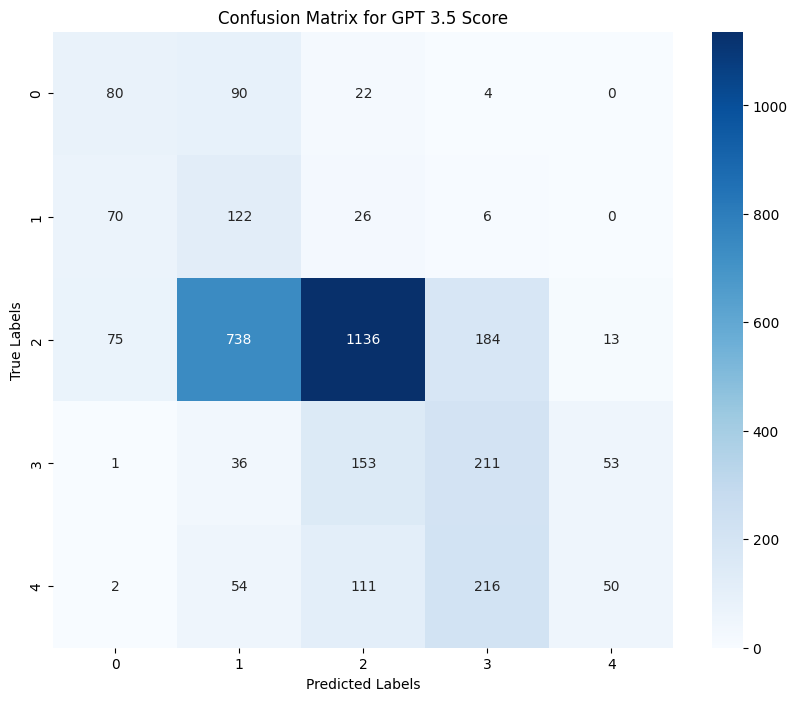

In [12]:
# Dictionary to store predictions and actuals for each model
model_predictions = {model: [] for model in models}
actual_labels = []

# Loop over the dataset files
for dataset_file in datasets:
    # Read the dataset
    df = pd.read_csv(dataset_file)
    
    # Extend the actual labels list
    actual_labels.extend(df['Actual_Score'])
    
    # For each model, extend the corresponding predictions list
    for model in models:
        model_predictions[model].extend(df[model])

# Now create and plot a confusion matrix for each model
for model in models:
    # Compute the confusion matrix
    cm = confusion_matrix(actual_labels, model_predictions[model])
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
